In [ ]:
# ISTA322 Final Project
# Author: Tugg Ernster
# Goal/Description: Taking raw data from the API websites of Spotify and Last.fm to create a comprehensive database of
# descriptors of rap artists to easily look at trends and relationships between these descriptors

In [ ]:
# Mount google drive, from the class notes
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)
!ls {nb_path}

In [ ]:
# This is where I installed all the necessary packages I used when creating this project, I would run this again
# just to make sure everything is working properly. I put a failsafe on where I needed to use them in everycell, I just
# commented them out, for whatever reason these don't work, you can just uncomment those statements
!pip install --target=$nb_path spotipy
!pip install mysql-connector-python
!pip install pymysql

In [ ]:
# Next, I imported all the packages I used throughout this code, this again should be ran to make everything run,
# I did run it without any issues on my end, but I put a failsafe on where I needed to use them in everycell, I just
# commented them out, for whatever reason these don't work, you can just uncomment those import statements
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyClientCredentials

import pandas as pd
import requests

import mysql.connector
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [ ]:
###import spotipy
###from spotipy.oauth2 import SpotifyClientCredentials

### This code just takes my individual client id and password from Spotify Api and
spotify_client_id = 'e5ea28f474684be6be411237ac4f3d46'
spotify_client_secret  = '2bd82fe94c3142cbb6463910398f074b'

client_credentials_manager = SpotifyClientCredentials(client_id=spotify_client_id, client_secret=spotify_client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
#import spotipy
#from spotipy.oauth2 import SpotifyClientCredentials
#import pandas as pd

## Function to search for artists by genre on Spotify and return data as DataFrame,
## I got a hefty amount of help from Chat GPT to make this function work!
def search_artists_by_genre_to_dataframe(genre, total_limit=1000):
    offset = 0
    data = []
    # Makes a while loop to look for artists while under the 1000 threshold
    while len(data) < total_limit:
      # Searches through 50 artists and grabs their respective data
        results = sp.search(q=f'genre:"{genre}"', type='artist', limit=50, offset=offset)
        artists = results['artists']['items']

        # This makes a check so that the artists are not repeated in the list and are unique
        unique_artists = [artist for artist in artists if artist['id'] not in {entry['ID'] for entry in data}]

        # Extracting the data from the artists
        for artist in unique_artists:
            artist_data = {
                'Artist': artist['name'],
                'ID': artist['id'],
                'Popularity': artist['popularity'],
                'Followers': artist['followers']['total'],
                'Genres': ", ".join(artist['genres']),}
            data.append(artist_data)
        # Just adds to the tally count by 50
        offset += 50


    return pd.DataFrame(data[:total_limit])

### Searches spotify by the key word rap with a limit of 1000
spotify_df = search_artists_by_genre_to_dataframe('rap', total_limit=1000)

### Just running a check to see what I am getting is what I want!
print(spotify_df)
# It works!

           Artist                      ID  Popularity  Followers  \
0           Drake  3TVXtAsR1Inumwj472S9r4          92   87070487   
1          Future  1RyvyyTE3xzB2ZywiAwp0i          90   16779939   
2    Metro Boomin  0iEtIxbK0KxaSlF7G42ZOp          90    7863846   
3    Travis Scott  0Y5tJX1MQlPlqiwlOH1tJY          90   28924090   
4      Kanye West  5K4W6rqBFWDnAN6FQUkS6x          90   25057972   
..            ...                     ...         ...        ...   
995     badchieff  6GoNVmYCl0yUm4pEp80vn6          60      66497   
996   Drex Carter  2zhgWhhKeDGw6gGd16y7tc          47      58024   
997        Laylow  0LnhY2fzptb0QEs5Q5gM7S          60     759529   
998     PE$O PETE  5B6civtd7qkaJGy3W5Q4M9          44      25979   
999          Nsqk  1jtvmXiemNFkPO11NMdjfu          57     164741   

                                                Genres  
0    canadian hip hop, canadian pop, hip hop, pop r...  
1    atl hip hop, hip hop, rap, southern hip hop, trap  
2           

In [ ]:
#import requests
#import pandas as pd

## Function to fetch top artists for a tag from Last.fm api. Again, I used Chat GPT heavily on this part,
## this was the hardest part by far in my code because the documentation was hard to understand

### Retrieves the top artists from Last.fm api
def get_top_artists(tag, api_key, limit=1000):
    url = "http://ws.audioscrobbler.com/2.0/"
    params = {
        "method": "tag.getTopArtists",
        "tag": tag,
        "api_key": api_key,
        "format": "json",
        "limit": limit
    }
    response = requests.get(url, params=params)
    ### Runs the code as long as we get a response from the Api
    if response.status_code == 200:
        data = response.json()
        ### Retrieves the top artist
        if "topartists" in data and "artist" in data["topartists"]:
            artists = data["topartists"]["artist"]
            return [artist["name"] for artist in artists]


### Function to fetch top tracks for an artist from Last.fm
def get_top_tracks(artist_name, api_key, limit=5):
    url = "http://ws.audioscrobbler.com/2.0/"
    params = {
        "method": "artist.getTopTracks",
        "artist": artist_name,
        "api_key": api_key,
        "format": "json",
        "limit": limit}
    response = requests.get(url, params=params)
    if response.status_code == 200:
      ### Performs the operation if it doesn't give error
        data = response.json()
        if "toptracks" in data and "track" in data["toptracks"]:
            tracks = data["toptracks"]["track"]
            track_info = []
            ### Retrieve the most popular 5 tracks for each top artist
            for track in tracks:
                track_info.append({
                    "Artist": artist_name,
                    "Name": track.get("name", ""),
                    "Playcount": int(track.get("playcount", 0)),
                    "Listeners": int(track.get("listeners", 0))})
            return track_info

### My Last.fm key
lastfm_api_key = "a28a487bd02ad1fcf6f38c38065b32bf"

## Find the top 1000 rappers, I know it says hip hop, but in Last.fm for whatever reason
## hip hop is the most prominent key for rappers
top_rappers = get_top_artists("hip-hop", lastfm_api_key, limit=1000)

### Create an empty list for tracks
all_tracks = []

### Gets top 5 tracks for each rapper and add them to the list
for rapper in top_rappers:
    rapper_tracks = get_top_tracks(rapper, lastfm_api_key)
    all_tracks.extend(rapper_tracks)

### Creates a dataframe
last_fm_df = pd.DataFrame(all_tracks)
### Just does a check to make sure everything is in order
print(last_fm_df)

### It works!

          Artist                         Name  Playcount  Listeners
0     Kanye West                     Stronger   18474834    2243104
1     Kanye West                    Heartless   21088621    2115070
2     Kanye West              Flashing Lights   21248881    1441404
3     Kanye West                  Gold Digger   11035065    1419117
4     Kanye West            All of the Lights   14475239    1413048
...          ...                          ...        ...        ...
4995     Yungmon                        Rauch      69831       4021
4996     Yungmon                     Crystals      54143       2770
4997     Yungmon  私は一人で死ぬ (Ich sterbe allein)      38937       2472
4998     Yungmon                    Adrenalin      53539       2464
4999     Yungmon                    Breakdown      42076       2272

[5000 rows x 4 columns]


In [ ]:
### Merges the existing data sets on the shared column of Artist
merged_df = pd.merge(last_fm_df,spotify_df, on='Artist', how='outer')
### Make sure everything looks in order, it does!
print(merged_df)

                                Artist               Name   Playcount  \
0                           Kanye West           Stronger  18474834.0   
1                           Kanye West          Heartless  21088621.0   
2                           Kanye West    Flashing Lights  21248881.0   
3                           Kanye West        Gold Digger  11035065.0   
4                           Kanye West  All of the Lights  14475239.0   
...                                ...                ...         ...   
5760  Rob Bailey & The Hustle Standard                NaN         NaN   
5761                         badchieff                NaN         NaN   
5762                            Laylow                NaN         NaN   
5763                         PE$O PETE                NaN         NaN   
5764                              Nsqk                NaN         NaN   

      Listeners                      ID  Popularity   Followers  \
0     2243104.0  5K4W6rqBFWDnAN6FQUkS6x        90.0  250

In [ ]:
## We did unforunately have some na values due to the merging of the data sets, so let's
## Get rid of them
merged_df = merged_df.dropna()
print(merged_df)

                 Artist                Name   Playcount  Listeners  \
0            Kanye West            Stronger  18474834.0  2243104.0   
1            Kanye West           Heartless  21088621.0  2115070.0   
2            Kanye West     Flashing Lights  21248881.0  1441404.0   
3            Kanye West         Gold Digger  11035065.0  1419117.0   
4            Kanye West   All of the Lights  14475239.0  1413048.0   
...                 ...                 ...         ...        ...   
4925  Junior M.A.F.I.A.           Get Money    671181.0   190126.0   
4926  Junior M.A.F.I.A.  I Need You Tonight     98839.0    36302.0   
4927  Junior M.A.F.I.A.     Player's Anthem    110065.0    34292.0   
4928  Junior M.A.F.I.A.      Players Anthem     57897.0    29698.0   
4929  Junior M.A.F.I.A.         Murder Onze     34038.0    19965.0   

                          ID  Popularity   Followers  \
0     5K4W6rqBFWDnAN6FQUkS6x        90.0  25057972.0   
1     5K4W6rqBFWDnAN6FQUkS6x        90.0  25057

In [ ]:
### I just used Drake,a popular rap artist, to make sure everything was looking somewhat correct
is_drake_in_df = 'Drake' in merged_df['Artist'].values
### Prints if my project is in ruins or not
if is_drake_in_df:
    print("Drake is here!")
else:
    print("It's Joever")

Drake is here!


In [ ]:
#!pip install mysql-connector-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 50.6 MB/s eta 0:00:00


In [ ]:
###import mysql.connector

## Took this code directly from the class notes, just replaces everything with my amazon login stuff
## I did have to use my sql to create the project1 database, but I have all my passwords and such so
## I believe it should be fine on your guys' end.
mysql_address  = 'project.czyauakkav3c.us-east-2.rds.amazonaws.com'
mysql_username='admin'
mysql_password='Bubblesman03$'

### We are going to use a single database for all databases in this course to avoid AWS charges.
### To avoid confusion, we use databasename_tablename naming convention.
mysql_database = 'project1'
### Just getting a connection to my database
def get_conn_cur():
    cnx = mysql.connector.connect(user=mysql_username, password=mysql_password,
          host=mysql_address,
          database=mysql_database, port='3306');
    return (cnx, cnx.cursor())
cnx, cur = get_conn_cur()
conn, cur = get_conn_cur()
conn

In [ ]:
#!pip install pymysql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00


In [ ]:
#import pandas as pd
#import mysql.connector
#from sqlalchemy import create_engine

## Here I define all my possible tables I would like to use later, including their primary keys, and other
## keys that are in the table

create_table_query_1 = """
CREATE TABLE IF NOT EXISTS rappers_table (
    Artist VARCHAR(255),
    Name VARCHAR(255),
    Playcount INT,
    Listeners INT,
    ID VARCHAR(255) PRIMARY KEY,
    Popularity INT,
    Followers INT,
    Genres VARCHAR(255));
"""

### Execute the SQL query to create the table
cur = conn.cursor()
cur.execute(create_table_query_1)
conn.commit()

create_table_query_2 = """
CREATE TABLE IF NOT EXISTS artist_information_table (
    Artist VARCHAR(255),
    ID VARCHAR(255) PRIMARY KEY,
    Followers INT,
    Genres VARCHAR(255));
"""
cur = conn.cursor()
cur.execute(create_table_query_2)
conn.commit()


create_table_query_3 = """
CREATE TABLE IF NOT EXISTS following_table (
    ID VARCHAR(255) PRIMARY KEY,
    Followers INT,
    Popularity INT);
"""
cur = conn.cursor()
cur.execute(create_table_query_3)
conn.commit()

create_table_query_4 = """
CREATE TABLE IF NOT EXISTS tracks_table (
    Artist VARCHAR(255),
    Name VARCHAR(255),
    Playcount INT,
    Listeners INT,
    ID VARCHAR(255) PRIMARY KEY);
"""
cur = conn.cursor()
cur.execute(create_table_query_4)
conn.commit()

In [ ]:
### Checks if all these tables exist
string = """SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'project1';"""

run_query(string)
### Cool, all of the tables have been created

,TABLE_NAME
0,artist_information_table
1,following_table
2,rappers_table
3,tracks_table


In [ ]:
#import pandas as pd
#from sqlalchemy import create_engine

### Create SQLAlchemy engine using the MySQL connector, had to do this or else it would not connect for some reason
### I got this code from Chat GPT
engine = create_engine(f"mysql+mysqlconnector://{mysql_username}:{mysql_password}@{mysql_address}/{mysql_database}")

### Create lists of columns from my dataframe that I want into my sql tables
artist_info = ['Artist','ID','Followers','Genres']
following_table = ['ID','Followers','Popularity']
tracks_table = ['Artist','Name','Playcount','Listeners','ID']

### Insert appropriate data from my dataframe into my the their respective correct tables
merged_df.to_sql(name='rappers_table', con=engine, if_exists='replace', index=False)
merged_df[artist_info].to_sql(name='artist_information_table', con=engine, if_exists='replace', index=False)
merged_df[following_table].to_sql(name='following_table', con=engine, if_exists='replace', index=False)
merged_df[tracks_table].to_sql(name='tracks_table', con=engine, if_exists='replace', index=False)

1175

In [ ]:
### Got this directly from class
def run_query(query_string):
  conn, cur = get_conn_cur() # get connection and cursor
  cur.execute(query_string) # executing string as before
  my_data = cur.fetchall() # fetch query data as before
  result_df = pd.DataFrame(my_data, columns=cur.column_names)

  cur.close() # close
  conn.close() # close

  return result_df


In [ ]:
## Just a check to see if we populated the tables correctly, look like we did, we know have set
## up the data where we can run query's to test show some relationships!
string = "SELECT * FROM rappers_table"
run_query(string)

,Artist,Name,Playcount,Listeners,ID,Popularity,Followers,Genres
0,Kanye West,Stronger,18474834.0,2243104.0,5K4W6rqBFWDnAN6FQUkS6x,90.0,25057972.0,"chicago rap, hip hop, rap"
1,Kanye West,Heartless,21088621.0,2115070.0,5K4W6rqBFWDnAN6FQUkS6x,90.0,25057972.0,"chicago rap, hip hop, rap"
2,Kanye West,Flashing Lights,21248881.0,1441404.0,5K4W6rqBFWDnAN6FQUkS6x,90.0,25057972.0,"chicago rap, hip hop, rap"
3,Kanye West,Gold Digger,11035065.0,1419117.0,5K4W6rqBFWDnAN6FQUkS6x,90.0,25057972.0,"chicago rap, hip hop, rap"
4,Kanye West,All of the Lights,14475239.0,1413048.0,5K4W6rqBFWDnAN6FQUkS6x,90.0,25057972.0,"chicago rap, hip hop, rap"
...,...,...,...,...,...,...,...,...
1170,Junior M.A.F.I.A.,Get Money,671181.0,190126.0,3r0OeTcOw37N9juMYyyw39,48.0,362590.0,"dirty south rap, east coast hip hop"
1171,Junior M.A.F.I.A.,I Need You Tonight,98839.0,36302.0,3r0OeTcOw37N9juMYyyw39,48.0,362590.0,"dirty south rap, east coast hip hop"
1172,Junior M.A.F.I.A.,Player's Anthem,110065.0,34292.0,3r0OeTcOw37N9juMYyyw39,48.0,362590.0,"dirty south rap, east coast hip hop"
1173,Junior M.A.F.I.A.,Players Anthem,57897.0,29698.0,3r0OeTcOw37N9juMYyyw39,48.0,362590.0,"dirty south rap, east coast hip hop"


In [ ]:
### First just wanna see what genres are most prevelant amoung the data set
genre_count = """SELECT Genres, COUNT(*) AS GenreCount
FROM artist_information_table
GROUP BY Genres
ORDER BY GenreCount DESC;"""
genre_count = run_query(genre_count)
print(genre_count)

                                                Genres  GenreCount
0                                        indie pop rap          30
1                                              pop rap          25
2              deep underground hip hop, indie pop rap          25
3        hip hop, pop rap, rap, southern hip hop, trap          15
4                                   sad lo-fi, sad rap          15
..                                                 ...         ...
202  battle rap, dirty south rap, southern hip hop,...           5
203           battle rap, hardcore hip hop, philly rap           5
204  crunk, dirty south rap, gangster rap, new orle...           5
205                                           cali rap           5
206                dirty south rap, east coast hip hop           5

[207 rows x 2 columns]


In [ ]:
## Calculate average follower count for each genre and order by average follower count
## I used Chat GPT to get the correct select statement and to be able to get all the genre's
## for every artist
query = """SELECT
    TRIM(SUBSTRING_INDEX(SUBSTRING_INDEX(genres, ',', n.digit+1), ',', -1)) AS Genre,
    SUM(Followers) AS SumFollowers
FROM
    artist_information_table
JOIN
    (SELECT 0 AS digit UNION ALL SELECT 1 UNION ALL SELECT 2 UNION ALL SELECT 3 UNION ALL SELECT 4) AS n
ON
    LENGTH(REPLACE(genres, ',' , '')) <= LENGTH(genres)-n.digit
GROUP BY
    Genre
ORDER BY
    SumFollowers DESC;

"""

### Execute the query
run_query(query)

# These results were as I originally suspected with the main categories being more
# prevelant while sub categories have less followers in general, however there are
# certaintly some outliers, such as canadian rap, from Drake.




,Genre,SumFollowers
0,rap,3.114363e+09
1,hip hop,2.559987e+09
2,pop rap,1.768181e+09
3,trap,7.690223e+08
4,southern hip hop,6.514304e+08
...,...,...
157,bossbeat,6.581450e+05
158,uk hip hop,6.239400e+05
159,uk drill,6.239400e+05
160,bounce,5.521450e+05


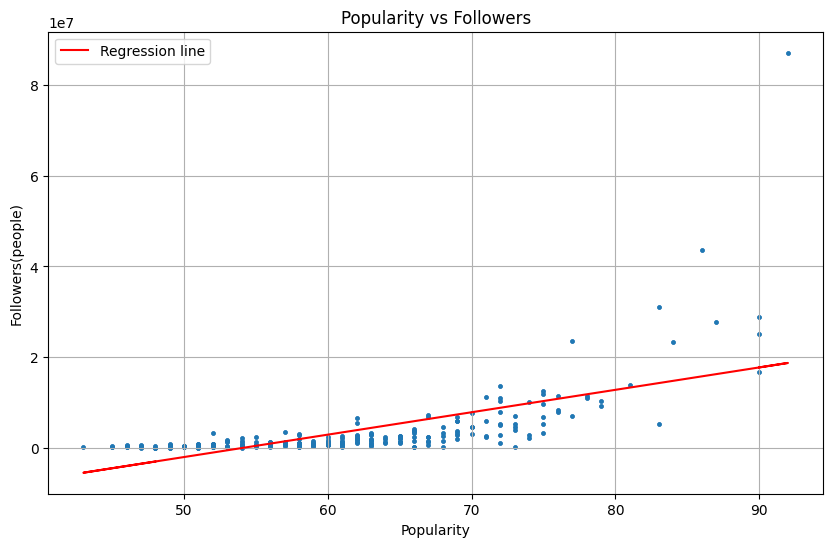

0.6423410589550352


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
### Get desired variables
query = """
SELECT Popularity, Followers
FROM following_table;
"""
### Run it
data = run_query(query)

### Convert the data into lists to use in plotting
popularity = data['Popularity'].tolist()
followers = data['Followers'].tolist()


### Calculate the coefficient between the two variables
correlation_coefficient = np.corrcoef(popularity, followers)[0, 1]

### Do linear regression
slope, intercept = np.polyfit(popularity, followers, 1)

### Plot
plt.figure(figsize=(10, 6))
plt.scatter(popularity, followers, alpha=0.5, s=5)
plt.plot(popularity, slope * np.array(popularity) + intercept, color='red', label='Regression line')
plt.title('Popularity vs Followers')
plt.xlabel('Popularity')
plt.ylabel('Followers(people)')
plt.grid(True)
plt.legend()
plt.show()

print(correlation_coefficient)
## This is good, but doesn't quite capture the trend that I would like to see, so let's make the followers
## axis a log scale, because of how varied the number of followers is

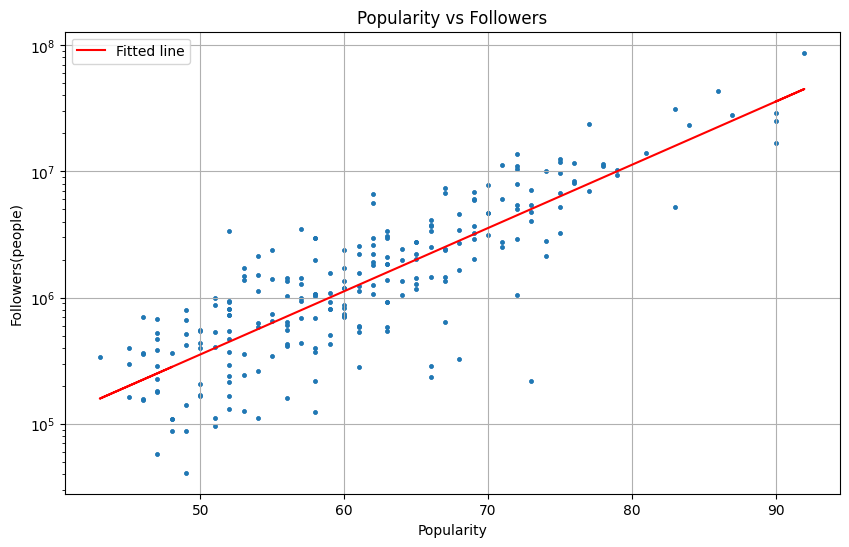

Correlation coefficient: 0.6423410589550352


In [ ]:
#import matplotlib.pyplot as plt
#import numpy as np
#from scipy.stats import linregress

### Gets popularity and followers from following table
query = """
SELECT Popularity, Followers
FROM following_table;
"""

### Execute the query
data = run_query(query)

### Extract popularity and followers from the query results

popularity = data['Popularity'].tolist()
followers = data['Followers'].tolist()


### Calculates the correlation coefficient
correlation_coefficient = np.corrcoef(popularity, followers)[0, 1]

### Transform followers to log scale
log_followers = np.log(followers)

### Performs linear regression
slope, intercept, r_value, p_value, std_err = linregress(popularity, log_followers)

### Plot
plt.figure(figsize=(10, 6))
plt.scatter(popularity, followers, alpha=0.5,s=5)


plt.plot(popularity, np.exp(slope * np.array(popularity) + intercept), color='red', label='Fitted line')

plt.title('Popularity vs Followers')
plt.xlabel('Popularity')
plt.ylabel('Followers(people)')
plt.yscale('log')  # Set logarithmic scale
plt.grid(True)
plt.legend()
plt.show()

print("Correlation coefficient:", correlation_coefficient)
### Much better looking!

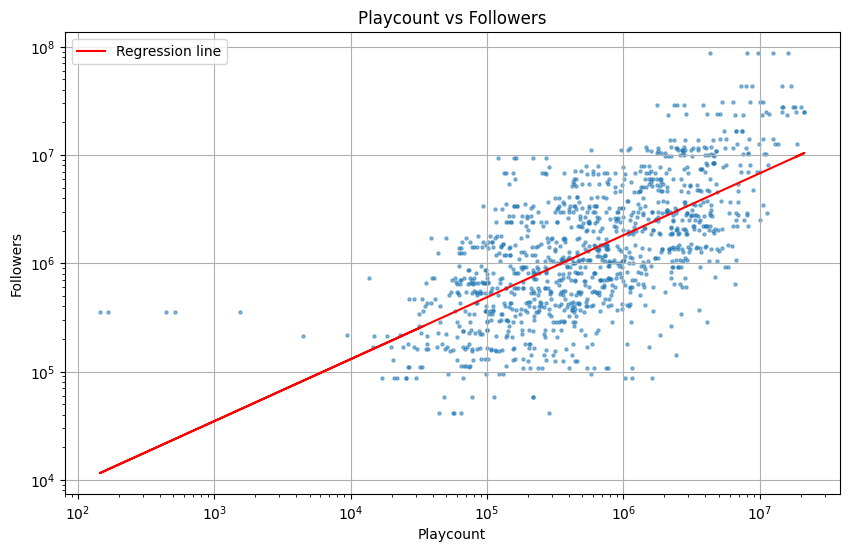

Correlation Coefficient: 0.6119759203543167


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

### Get playcount
query1 = """
SELECT Playcount
FROM tracks_table;
"""

### Execute the query
data1 = run_query(query1)

### Get playcount
query2 = """
SELECT Followers
FROM artist_information_table;
"""

### Execute the query
data2 = run_query(query2)


### Make these into lists
playcount = data1['Playcount'].tolist()
followers = data2['Followers'].tolist()

### Transform the data list values to their logs
log_followers = np.log(followers)
log_playcount = np.log(playcount)

### Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(log_playcount, log_followers)

### Plot playcount vs followers with logarithmic scaling
plt.figure(figsize=(10, 6))
plt.scatter(playcount, followers, alpha=0.5, s=5)
plt.title('Playcount vs Followers')
plt.xlabel('Playcount')
plt.ylabel('Followers')
plt.xscale('log')
plt.yscale('log')

### Plot regression line
plt.plot(playcount, np.exp(intercept) * playcount**slope, color='red', label='Regression line')
plt.grid(True)
plt.legend()
plt.show()

### Calculate correlation coefficient
correlation_coefficient = np.corrcoef(playcount, followers)[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient}")

